# 4 point Thermometry Analysis ONLY

This script will be used purely to analyse the results of the 4 point ODMR measurements using only the temperature sensing algorithms as defined in the papers:
1. Singam et al (2019) - Nitrogen-vacancy nanodiamond based local thermometry using frequency-jump modulation
2. Fujiwaraet al (2020) - Real-time nanodiamond thermometry probing in vivo thermogenic responses. 

The aim of writing this script is to tidy up the original frankenstien script currently at the time of writing called: 
20210617_Analysis_Referenced_4_point_ODMR.ipynb

Unfortunately, I think I need to call in basically all the same functions and perform basically all the same analysis, but I will have fewer outputs and will structure everything a little bit nicer so that I can run everything from a single "main" cell at the bottom of the script and know that everything will get pulled in properly... I might have it so that any full CW ODMR script analysis is done in a separate cell just so I don't end up bogging down the whole script everytime it runs. 

In [2]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd
from scipy.signal import find_peaks

Pull in the data files and the associated params file. Also make the plots big enough to actually be able to see what's going on and read what's on the graphs. 

In [3]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [4]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Creates a numpy array with the microwave frequency scan range from the params file. 

In [6]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    return(freq)

Here we have the code to reshape the ODMR data into a 3D dataset according to the parameters that are given in the Params.txt file. 

Once the ODMR and reference Datasets have been restructured, then we can perform the normalisation of the ODMR dataset to the reference dataset.  

In [7]:
def reshape_data(reference_data, odmr_data, params_values):
    '''Here we re-shape the reference and the ODMR datasets into a 3D array, 
    based on the number of line scans, frequnecy points and repeats per frequnecy 
    have been used to build the ODMR dataset.'''
    
    # Create variables with the frequnecy scan parameters. 
    num_of_line_scans = int(params_values[4])
    num_of_freqs =  int(1000*(params_values[1]-params_values[0])/params_values[2]) + 1
    points_per_freq = int(params_values[8])
    print(num_of_line_scans, num_of_freqs, points_per_freq)
    # Reshape the ODMR and reference datasets. 

    odmr_shape_3D = odmr_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    reference_data_3D = reference_data[0:num_of_freqs*points_per_freq].reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    
    return(odmr_shape_3D, reference_data_3D)

In [8]:
def normalise_data(reference_data, odmr_data):
    '''Here we normalise the ODMR dataset to the reference data.'''

    norm_odmr_data = odmr_data/reference_data
    return(norm_odmr_data)

Find the mean of the ODMR dataset.

In [9]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data_points =  np.mean(odmr_data, axis = 2)
    mean_odmr_data_points_and_linescans =  np.mean(mean_odmr_data_points, axis = 0)
    return(mean_odmr_data_points, mean_odmr_data_points_and_linescans)

Plot the Normalised ODMR data to a graph.

In [10]:
def normalised_scatter_plot(freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts (A.U.)', fontsize = 18)
    return(fig2, ax2)

Get the fitting parameters from the ODMR dataset and use these to fit a double Lorentzian lineshape to the normalised ODMR dataset.

In [11]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    
    half_data_length = int((len(freq)-1)/2) # This brings the mid-value to 2.87GHz 
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [12]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [13]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [14]:
def plot_fitting(ax2, freq, dwell_time):
    # plot the y fit. 
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 10*len(freq)+1)
    
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    
    return(ax2, y_fit)

In [15]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

*************************************************************************************************************************************************************************************

### Full CW ODMR Analysis

This should be a fairly base level referenced ODMR dataset analysis. From this, we should be able to reshape, normalise and plot the ODMR data.  
Additionally, I should be able to extract the Double Lorentz fitting of the dataset as it is needed for some of the further analysis.

*****************************************************************

1 261 100
[2.8645, 2.8655]
10000.0
0.007749424148000004 0.00750208223567919


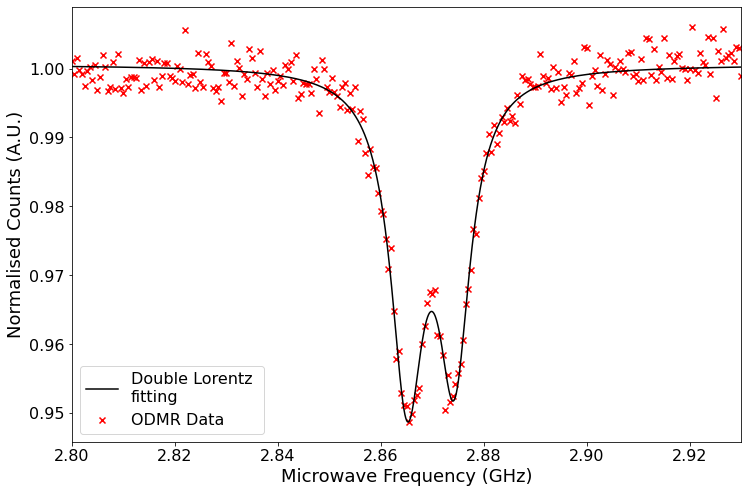

In [16]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

date = '20211216' # Date on folder in which the experimental data is saved. 
set_plot_params()

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\2021\\' + date + '\\'
#folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'

data_set = '_referenced_odmr_06' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
file_name_ODMR1 = date + data_set + '_ODMR1.dat'
file_name_ODMR2 = date + data_set + '_ODMR2.dat'
file_name_Ref1 = date + data_set  + '_Ref1.dat'
file_name_Ref2 = date + data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
odmr_data = load_data(folder_path + file_name_ODMR1)
reference_data = load_data(folder_path + file_name_Ref1)

# Get the parameters for the experiment. 
params_file = load_params(folder_path + date  + data_set + '_Params.txt')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
# Freq scan = frequency scan actually used in experiment, frreq = scan without triggering problems. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# Dwell time of the measurment 
dwell_time = params_values[3]

# Reshape the ODMR and reference datasets. 
odmr_data, reference_data = reshape_data(reference_data, odmr_data, params_values)

# Normalise the ODMR data against the reference data. 
normalised_ODMR = normalise_data(reference_data, odmr_data)

# Mean of the normalise dataset. 
# mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
# mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
mean_odmr_freq_points, mean_norm_odmr_full_disordered = mean_data(normalised_ODMR)
mean_norm_odmr_full = np.roll(mean_norm_odmr_full_disordered, 1)

# Plot the mean normalised dataset as a scatter plot. 
fig1, ax1 = normalised_scatter_plot(freq, mean_norm_odmr_full)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(mean_norm_odmr_full, freq)
print(freq_mins)


# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]
init_params = [-0.8, 2.86, 0.005, dip_depth[1], 2.87, 0.005, flourescent_baseline]

# Set the upper and lower bounds for the fitting algorithm. 
lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, mean_norm_odmr_full, init_params,
                                                    lower_bounds, upper_bounds)

# plot the fitting to ax1
ax1, y_fit = plot_fitting(ax1, freq, params_values[3])
print(dwell_time)
print(fitting_params[2], fitting_params[5])

***

### Begin the 4 point ODMR Analysis

Here I plan to:
1. Read in the 4 point ODMR data and the corresponding reference dataset.
2. Plot the normalised 4 point ODMR dataset against the fitted double Lorentz curve along with the intensitied of the 4 frequency points as expected from the fitted curve. 
3. Perform the analysis of the 4 point ODMR data using the method propsed by Fujiwara et al (2020).
4. perform the analysis of the 4 point ODMR dataset using the method proposed by Singam et al (2019). 

I will aim to make both the analysis methods such that it can take both a single mean value from the dataset and can analyse the full dataset to give a mean value for the T (or $\delta$D) and the standard deviation in the recorded values. This allows us to apply an error value to the recorded datapoints, which is probably a good thing.  

In [17]:
def normalise_data_error_propogation(norm_odmr_4_point, four_point_reference_data, four_point_odmr_data, repeats):
    '''Calculating the error associated with each of the individual repeats of the 4 frequnecy points in the dataset.'''
    
    mean_norm_4_point_intensity = np.mean(four_point_odmr_data, axis = 2)
    mean_norm_4_point_ref_intensity = np.mean(four_point_reference_data, axis = 2)
    
    delta_I_odmr = (2.2 * np.sqrt(mean_norm_4_point_intensity))/(mean_norm_4_point_intensity*np.sqrt(repeats))
    delta_I_ref = (2.2 * np.sqrt(mean_norm_4_point_ref_intensity))/(mean_norm_4_point_ref_intensity*np.sqrt(repeats))
    
    delta_I_normalised = norm_odmr_4_point * np.sqrt(delta_I_odmr**2 + delta_I_ref**2)
    
    return(delta_I_normalised)

In [18]:
def get_two_freqs(four_freqs, f_step):
    '''Find the mean applied frequencies needed for Singam analysis. '''
    
    # Calculate the mean applied frequencies
    f_minus = (four_freqs[0] + four_freqs[1])/2
    f_plus = (four_freqs[2] + four_freqs[3])/2
    
    # Find the difference in frequency points applied. 
    delta_applied_f = f_plus - f_minus
    
    # Find the frequency difference in terms of indicies in the frequency array. 
    indice_shift = int(delta_applied_f/(f_step*0.001))
    
    return(f_minus, f_plus, indice_shift)   

In [19]:
def get_two_reference_intensities(two_freqs, y_fit, freq):
    '''From the double lonentz fitting for the ODMR curve get the two intensities 
    that correspond to the two applied frequencies.'''
    
    indicies = []
    
    # Find the two frequencies indices in the frequency array. 
    indicies.append(np.abs(freq - two_freqs[0]).argmin())
    indicies.append(np.abs(freq - two_freqs[1]).argmin())
    
    # Find the reference intensities from the y fit
    reference_intensities = np.array([y_fit[indicies[0]], y_fit[indicies[1]]])
    
    # Ccalculate the reference intensity differences
    reference_I_diff = reference_intensities[0] - reference_intensities[1]

    return(reference_intensities, reference_I_diff)

In [20]:
def get_two_measured_intensities(four_freq_intensities, intensity_errors):
    '''Get the two Intensities corresponding to the two frequencies used in the singam analysis'''
    
    # Caluclate the mean intensity for the straight line plots on the 
    # negative gradient of the ODMR dip. 
    I_minus = (four_freq_intensities[0] + four_freq_intensities[1])/2
    I_minus_error = np.sqrt(np.power(intensity_errors[0],2) + np.power(intensity_errors[1],2))
    
    I_plus = (four_freq_intensities[2] + four_freq_intensities[3])/2
    I_plus_error = np.sqrt(np.power(intensity_errors[2],2) + np.power(intensity_errors[3],2))
    
    return(I_minus, I_minus_error, I_plus, I_plus_error)

In [21]:
def calc_measured_I_diff(I_minus, I_minus_error, I_plus, I_plus_error):
    '''Find the difference in the measured intensity from the 4 point ODMR measurement.'''
    
    I_diff = (I_minus - I_plus)
    error_I_diff = np.sqrt(np.power(I_minus_error, 2) + np.power(I_plus_error, 2))
    
    return(I_diff, error_I_diff)

In [22]:
def singam_subtraction_array(y_fit, f_step, freq, index_shift):
    '''We create the arrays for the subtraction curve used as a reference to determine the shift in the frequency of the ODMR curve.'''
    
    # find the length of the array - the difference between 
    # indcies for f_plus and f_minus
    subtraction_curve_length = len(freq) - index_shift
    
    # Create variables for subtraction plot. 
    y_fit_subtract = []
    
    # Here we create an array for the double lorentz fitting 
    # in which we perform the following calc. 
    # I_subtract = I(0) - I(index shift)
    for i in range(subtraction_curve_length):
        y_fit_subtract.append(y_fit[i] - y_fit[i + index_shift])
    
    # Turn the list into an array. 
    y_fit_subtract = np.array(y_fit_subtract)

    
    # create a frequnecy subtraction array for the above. 
    freq_sub_array = np.linspace(0, subtraction_curve_length-1, subtraction_curve_length)
    freq_sub_array = (freq_sub_array - int(subtraction_curve_length/2))*f_step
    
    return(y_fit_subtract, freq_sub_array)

In [23]:
def singam_extract_linear(f_step, y_fit_subtract):
    '''Here we extract the linear part of the subtracting curve as created in the above method.'''
    
    # How many frequnecy steps are needed to generate a +/- 3MHz region of the data
    pm_3_mhz = int(3/f_step)
    
    # find the max and min for the subtracted ODMR curve. 
    maxima = np.where(y_fit_subtract == np.max(y_fit_subtract))[0]
    minima = np.where(y_fit_subtract == np.min(y_fit_subtract))[0]
    
    # find the frequnecy equvilent to the point at which I(f1) and I(f4) are equal. 
    zero_intensity_freq = np.abs(y_fit_subtract[maxima[0]:minima[0]] - 0.00).argmin() + maxima[0]

    # the limits of the straight line portion of the subtracted ODMR curve. 
    min_index = zero_intensity_freq-pm_3_mhz
    max_index = zero_intensity_freq+pm_3_mhz
    
    return(zero_intensity_freq, max_index, min_index)

In [24]:
def straight_line(x, m, c):
    '''y = mx + c'''
    y = m*x + c
    return(y)

In [25]:
def singam_analysis_3(delta_I_measured, error_delta_I, delta_I_ref, linear_fit_params, linear_fit_errors):

#(mean_norm_4_point_odmr_full, error_4_points, linear_fit_params, linear_fit_errors, y_fit, nd_locs):
    '''Here we perform the analysis of the 4 point ODMR dataset using the method outlined in Singam's paper from 2019'''
    
    m = linear_fit_params[0]
    c = linear_fit_params[1]
    delta_m = linear_fit_errors[0]
    delta_c = linear_fit_errors[1]
    
    measured_freq_change = (delta_I_measured - c)/m
    error_part_1 = np.sqrt(np.power(error_delta_I, 2) + np.power(delta_c, 2))
    
    error_part_2 = measured_freq_change * (np.sqrt(np.power((error_part_1/(delta_I_measured - c)), 2) + 
                                                  np.power((delta_m/m),2)))
    
    # Calculate the fitting frequency difference. 
    reference_freq_change = (delta_I_ref - c)/m

    return(measured_freq_change, error_part_2, reference_freq_change)

In [26]:
def save_data(file_ID, date, dwell_time, repeats, deltaD, error_deltaD, deltaT, error_deltaT, mean_intensity, analysis_type):
    '''Save the data in a .txt file. The analysis method determines what file the data is saved to. 
    We are saving: the file name, Dwell time in ms, Resonant frequency from temperature measurement theory D(T), STD(D(T)), Approx temperature change T, 
    STD(T), mean Intensity per measurement, sqrt Intensity'''
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\' + date + '\\' 
    output_data_file = destination_folder + date + '_' + analysis_type + '_reference_4_point_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name'  + ' \t' + 'Dwell Time (ms)' + ' \t' + 'Repeats per applied freq' + '\t' + 
                     'Calculated change in res freq (kHz)' + ' \t' + 'error Calculated change in res freq (kHz)' + ' \t' +
                     'Change in Temp (oC)' + ' \t' + 'error Change in Temp (oC)' + ' \t' + 
                     'Mean Intensity (counts per dwell time)' + ' \t' +
                     'SQRT(Mean Intensity (sqrt(counts per dwell time)))' + '\n')

    with open(output_data_file, "a") as wf:
        wf.write(date+file_ID  + '\t' +
                 str(dwell_time) + " \t"  +  str(repeats) + '\t' +
                 str(deltaD*1000) + " \t" +  str(error_deltaD*1000) + ' \t' +
                 str(deltaT) + " \t" +  str(error_deltaT) + " \t" + str(mean_intensity) + " \t"  + 
                 str(np.sqrt(np.round(mean_intensity, 3))) + '\n')        
    

# *** 
### Here we analyse the 4 point referenced ODMR data
***

1 4 200
[[33448.045 33247.85  33675.895 33518.1  ]]
[[402.35374709 401.14784556 403.72184954 402.77488005]]
[2.8005 2.801 ]
[123 127 151 155]


Text(0, 0.5, 'Normalised Counts (A.U.)')

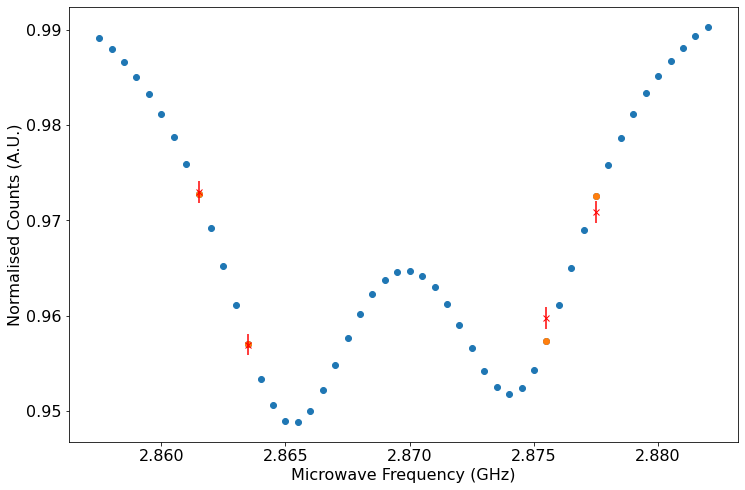

In [27]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.

folder_path_2 = folder_path + 'simulated_temp_change\\'

four_point_data_set = '_4_point_referenced_odmr_71' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
four_point_file_name_ODMR1 = date + four_point_data_set + '_ODMR1.dat'
four_point_file_name_ODMR2 = date + four_point_data_set + '_ODMR2.dat'
four_point_file_name_Ref1 = date + four_point_data_set  + '_Ref1.dat'
four_point_file_name_Ref2 = date + four_point_data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
four_point_odmr_data = load_data(folder_path_2 + four_point_file_name_ODMR1)
four_point_reference_data = load_data(folder_path_2 + four_point_file_name_Ref1)

# Get the parameters for the experiment. 
four_point_params_file = load_params(folder_path_2 + date  + four_point_data_set + '_Params.txt')
four_point_params_values = four_point_params_file['Parameter value']

# Need to have the four_freqs array layered as follows [F1, F2, F3, F4] due to riggering problems in the software.  
four_freqs = [2.8615 ,2.8635, 2.8755, 2.8775]
repeats = four_point_params_values[8]

# Reshape the data so that it can be used for the following script. 
four_point_odmr_data, four_point_reference_data = reshape_data(four_point_reference_data, 
                                                               four_point_odmr_data, four_point_params_values)

mean_total_intensity = np.mean(four_point_reference_data)

mean_four_point_intensity = np.mean(four_point_odmr_data, axis = 2)
mean_reference_intensity = np.mean(four_point_reference_data, axis = 2)

# Generate the error arrays for the ODMR and reference data. 
four_points_ODMR_error = 2.2 * np.sqrt(mean_four_point_intensity) # shot noise limit approximation
four_points_reference_error = 2.2 * np.sqrt(mean_reference_intensity) # shot noise limit approximation

print(np.mean(four_point_odmr_data, axis = 2))
print(four_points_ODMR_error)


# Normalise the ODMR data against the reference data. 
norm_odmr_4_point = normalise_data(four_point_reference_data, four_point_odmr_data)
# Mean of the normalise dataset.
mean_odmr_4_point_freq_points, mean_norm_4_point_odmr = mean_data(norm_odmr_4_point)

# Find the error for the normaised dataset. 
norm_ODMR_errors = normalise_data_error_propogation(np.mean(norm_odmr_4_point, axis = 2), 
                                                              four_point_reference_data, four_point_odmr_data,
                                                             repeats)

# roll the values +1 spaces in the array to correct for problems in the measurement regime. 
mean_norm_4_point_odmr = np.roll(mean_norm_4_point_odmr, 1)
norm_ODMR_errors = np.roll(norm_ODMR_errors, 1)

#plot.plot(freq[45*7:90*7], y_fit[45*7:90*7], color = 'k')
print(freq[1:3])
indices = []
indices.append((np.abs(freq - four_freqs[0])).argmin())
indices.append((np.abs(freq - four_freqs[1])).argmin())
indices.append((np.abs(freq - four_freqs[2])).argmin())
indices.append((np.abs(freq - four_freqs[3])).argmin())

indices = np.array(indices)
print(indices)
plot.scatter(freq[115:165], y_fit[115:165])
plot.scatter(freq[indices], y_fit[indices], marker = 'o')

plot.errorbar(four_freqs, mean_norm_4_point_odmr, norm_ODMR_errors[0], color = 'r', marker = 'x',
             linestyle = '')
plot.xlabel('Microwave Frequency (GHz)')
plot.ylabel('Normalised Counts (A.U.)')


***

### Singam Analysis
***

In [28]:
# Analyisis type 
analysis_type = 'Singam_analysis_thesis_script'

# Find the mean frequency measured on either side of the ODMR dip.
f_minus, f_plus, index_shift = get_two_freqs(four_freqs, params_values[2])

# Find the corresponding mean intensity from the four point 
# ODMR data. 
I_minus, I_minus_error, I_plus, I_plus_error = get_two_measured_intensities(mean_norm_4_point_odmr, 
                                                                            norm_ODMR_errors[0])

# Find the reference intensity from the y_fit data to be used for the Signam analysis
# as well as the intensity difference between the two points for the steady state. 
reference_intensities, reference_I_diff = get_two_reference_intensities([f_minus, f_plus], y_fit, freq) 

# Caclulate the difference between the two mean intensities from the 
# two sides of the ODMR dip. 
I_diff, error_I_diff = calc_measured_I_diff(I_minus, I_minus_error, I_plus, I_plus_error)

# Create the subtraction plots (see plot for what this looks like).
y_fit_subtract, freq_sub_array = singam_subtraction_array(y_fit, params_values[2], freq, index_shift)

# Find the indicies corresponding to the maxima and minima of the y_fit subtracted lineshape.
# Also have the index corresponding to I(f1) - I(f2) = 0
zero_intensity_freq, max_index, min_index = singam_extract_linear(params_values[2], y_fit_subtract)

# Fit a straight line fit to the linear part of the subtraction curve. 
p0 = [0,0]
fit_coeffs, confidence = opt.curve_fit(straight_line, freq_sub_array[min_index:max_index], y_fit_subtract[min_index:max_index], p0)
linear_fit_errors = np.sqrt(np.diag(confidence))

# Generate a high resolution x and y straight line fit for the linear portion of the subtraction curve. 
freq_high_res = np.linspace(freq_sub_array[min_index], freq_sub_array[max_index], 1000)
linear_fit = straight_line(freq_high_res, fit_coeffs[0], fit_coeffs[1])

#plot.plot(freq_sub_array, y_fit_subtract)
#plot.plot(freq_high_res, linear_fit)

measured_freq_change, error_measured_freq_change, reference_freq_change = singam_analysis_3(I_diff, 
                                                                              error_I_diff, 
                                                                              reference_I_diff,
                                                                              fit_coeffs, linear_fit_errors)

calculated_freq_change = reference_freq_change - measured_freq_change

# Calculated temperature change and error. 
# 0.075kHzK^-1 Acosta et al's measurement of change in res freq of NV
# with temperature. 
deltaT = calculated_freq_change / 0.075 
error_deltaT = deltaT * (error_measured_freq_change/calculated_freq_change)

#save_data(four_point_data_set, date, dwell_time, repeats, calculated_freq_change, error_measured_freq_change, 
#          deltaT, error_deltaT, mean_total_intensity, analysis_type)


#print(str(measured_freq_change - reference_freq_change) + 'MHz')
#print(error_measured_freq_change)

In [28]:
# Analysis of the 4 point ODMR is a little more challenging using the Singam protocol.

# Get the mean frequency values and the number of frequency steps between the two mean freq values. 
f_minus, f_plus, index_shift = singam_freq_diff(four_freqs, params_values[2])
# Create the subtraction plots (see plot for what this looks like).
y_fit_subtract, freq_sub_array = singam_subtraction_array(y_fit, params_values[2], freq, index_shift)

plot.plot(freq_sub_array, y_fit_subtract)
plot.xlabel('Subtracted frequency (MHz)')
plot.ylabel('Intensity differences (A.U.)')
plot.title('Subtracted ODMR curve')
plot.show()

# Find the indicies corresponding to the maxima and minima of the y_fit subtracted lineshape.
# Also have the index corresponding to I(f1) - I(f2) = 0
zero_intensity_freq, max_index, min_index = singam_extract_linear(params_values[2], y_fit_subtract)

# Fit a straight line fit to the linear part of the subtraction curve. 
p0 = [0,0]
fit_coeffs, confidence = opt.curve_fit(straight_line, freq_sub_array[min_index:max_index], y_fit_subtract[min_index:max_index], p0)
linear_fit_errors = np.sqrt(np.diag(confidence))

print(fit_coeffs, linear_fit_errors)

# Generate a high resolution x and y straight line fit for the linear portion of the subtraction curve. 
freq_high_res = np.linspace(freq_sub_array[min_index], freq_sub_array[max_index], 1000)
linear_fit = straight_line(freq_high_res, fit_coeffs[0], fit_coeffs[1])

# Find the location of F_plus and F_minus in the normal frequency array. 
two_freq_locs = []
for i in range(2):
    a = ((four_freqs[i*2] + four_freqs[i*2 + 1])/2)
    two_freq_locs.append(np.abs(np.round(freq, 5) - a).argmin())



# Plot the high resolution straight line fit.
plot.plot(freq_high_res, linear_fit)
# Plot the points used to generate the original y_fit_subtraction curve. 
plot.scatter(freq_sub_array[min_index:max_index], y_fit_subtract[min_index:max_index])    

# Perform the Singam analysis for the mean of the 2 mean values from the 4 point ODMR data. Plus error analysis. 
I_diff_2_points, error_I_diff_mean, I_diff_mean_ref, two_point_freq_shift, error_two_point_freq_shift, singam_reference_value = singam_analysis_2(mean_norm_4_point_odmr, 
                                                                                                                               four_point_mean_norm_error, 
                                                                                                                               fit_coeffs, 
                                                                                                                               linear_fit_errors, 
                                                                                                                               y_fit, two_freq_locs)

print(two_point_freq_shift, error_two_point_freq_shift, singam_reference_value)                                                                                                                               

# plot the reference value and the subtraction curve sampling points. 
plot.errorbar(two_point_freq_shift, I_diff_2_points, error_I_diff_mean, 
              marker = 'x', label = 'T shift', color = 'k')
plot.scatter(singam_reference_value, I_diff_mean_ref, marker = 'x', label = 'ref')
plot.xlabel('Frequnecy Difference (MHz)')
plot.ylabel('Intensity Difference (Normalised Counts)')
plot.title('Singam et al. T sensing calibration graph')
plot.legend()

# find the change in the resonant frequnecy of the NV centres from the reference.
delta_f_singam_plus_error =  (two_point_freq_shift + error_two_point_freq_shift) - singam_reference_value # MHz
delta_f_singam_minus_error = (two_point_freq_shift - error_two_point_freq_shift) - singam_reference_value # MHz

mean_delta_f_singam = (delta_f_singam_plus_error + delta_f_singam_minus_error)/2
error_delta_f_singam = np.abs(delta_f_singam_plus_error - delta_f_singam_minus_error)

print(delta_f_singam_plus_error, delta_f_singam_minus_error)
# Find the temperature change in the sample. 
delta_T_singam = mean_delta_f_singam/(-0.075)
print(delta_T_singam, error_delta_f_singam/(-0.075))

try: 
    delta_f_singam_store.append(mean_delta_f_singam) # MHz
    delta_T_singam_store.append(delta_T_singam) # Kelvin
except:
    delta_f_singam_store = []
    delta_T_singam_store = []
    delta_f_singam_store.append(mean_delta_f_singam)
    delta_T_singam_store.append(delta_T_singam)

#print(two_point_freq_shift, singam_reference_value)

analysis_type = 'Singam_2019_2__T_sensing_'
    
#save_data(four_point_data_set, date, four_point_params_values[3]/1000, four_point_params_values[8],
#          two_point_freq_shift, error_two_point_freq_shift[0], delta_T_singam[0], error_delta_f_singam[0], np.mean(four_point_reference_data), analysis_type)

#print(delta_f_singam_store)
#print(delta_T_singam_store)

NameError: name 'singam_freq_diff' is not defined

***

In [29]:
print(np.mean(delta_f_singam_store))
print(np.std(delta_f_singam_store))

NameError: name 'delta_f_singam_store' is not defined

In [56]:
def percent_diff(sub_I_point, linear_fit_point): 
    '''Find the percentage difference between two points between the subtraction curve and 
    the linear fit. '''
        
    diff = np.sqrt(np.power((sub_I_point - linear_fit_point), 2))
    
    if sub_I_point < 0: 
        sub_I_point = sub_I_point * -1
    
    percentage = 100*(diff/sub_I_point)
    
    return(percentage)
    

In [60]:
def cubic(x, A, B, C, D):
    '''Generate a cubic relationship. '''
    
    y = A*x**3 + B*x**3 + C*x + D
    
    return (y)

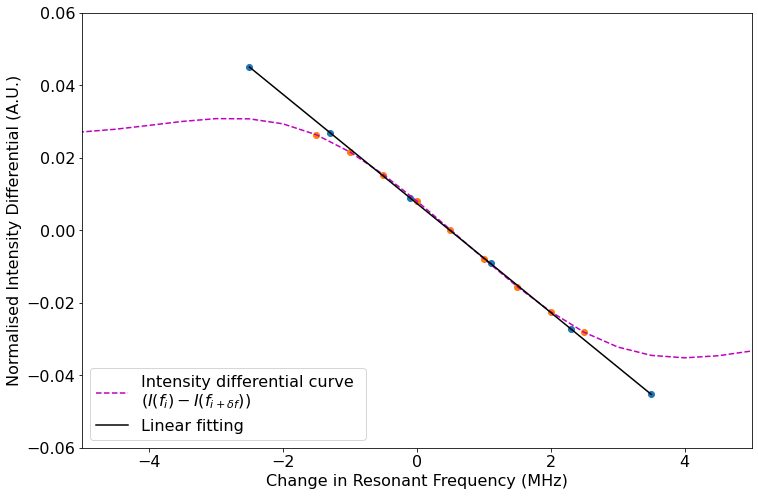

In [190]:
# Fit a straight line fit to the linear part of the subtraction curve. 
p0 = [0,0]

centred_freq_sub_array = freq_sub_array - 4

fit_coeffs, confidence = opt.curve_fit(straight_line, centred_freq_sub_array[122:128], y_fit_subtract[122:128], p0)
linear_fit_errors = np.sqrt(np.diag(confidence))

# Generate a high resolution x and y straight line fit for the linear portion of the subtraction curve. 
freq_high_res = np.linspace(centred_freq_sub_array[119], centred_freq_sub_array[131], 6)
linear_fit = straight_line(freq_high_res, fit_coeffs[0], fit_coeffs[1])

fig6, ax6 = plot.subplots()

ax6.plot(centred_freq_sub_array, y_fit_subtract, label = 'Intensity differential curve \n' + r'$( I(f_i) - I(f_{i + \delta f}) )$', 
        linestyle = '--', color = 'm')
ax6.plot(freq_high_res, linear_fit, label = 'Linear fitting', color = 'k')

ax6.set_xlabel('Change in Resonant Frequency (MHz)')
ax6.set_ylabel('Normalised Intensity Differential (A.U.)')
ax6.axis([-5, 5, -0.06, 0.06])
ax6.legend(loc = 'lower left')

get_r_squared(freq_sub_array[122:128], linear_fit, y_fit_subtract[122:128])

plot.scatter(freq_high_res, linear_fit)

plot.scatter(centred_freq_sub_array[121:130], y_fit_subtract[121:130])


#fig6.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\' + 'Signam_analysis_02' + '.pdf')

191 725
1.46996996996997
19.5995995995996


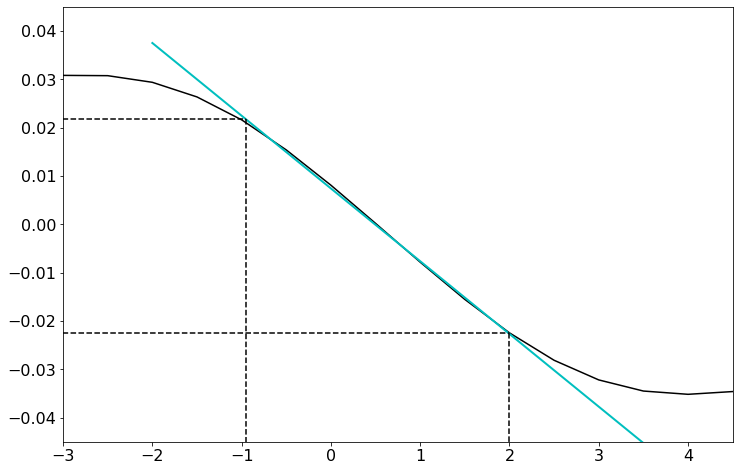

In [223]:
# Find the viable range for the linear approximation. 
high_resolution_x = np.linspace(centred_freq_sub_array[120], centred_freq_sub_array[131], 1000)
y_high_res = straight_line(high_resolution_x, fit_coeffs[0], fit_coeffs[1])

high_limit = 1.005 * y_fit_subtract[122]
low_limit = 1.005 * y_fit_subtract[128]

store = []

for i in range(len(high_resolution_x)):
    if y_high_res[i] < high_limit and y_high_res[i] > low_limit:
        store.append(i)
        
print(store[0], store[-1])
#print(high_resolution_x[store[0]], high_resolution_x[store[-1]])       

plot.plot(centred_freq_sub_array[115:135], y_fit_subtract[115:135],
         color = 'k')

plot.plot(high_resolution_x, y_high_res, linewidth = '2', color = 'c')

#plot.plot(high_resolution_x[store], y_high_res[store], color = 'r')


plot.plot([centred_freq_sub_array[115], high_resolution_x[store[0]]], [y_high_res[store[0]],y_high_res[store[0]]],
         linestyle = '--', color = 'k')
plot.plot([centred_freq_sub_array[115], high_resolution_x[store[-1]]], [y_high_res[store[-1]],y_high_res[store[-1]]],
         linestyle = '--', color = 'k')

plot.plot([high_resolution_x[store[0]], high_resolution_x[store[0]]], [y_high_res[store[0]], -0.045],
         linestyle = '--', color = 'k')

plot.plot([high_resolution_x[store[-1]], high_resolution_x[store[-1]]], [y_high_res[store[-1]], -0.045],
         linestyle = '--', color = 'k')

plot.axis([-3, 4.5, -0.045, 0.045])


freq_span = (high_resolution_x[store[-1]] - high_resolution_x[store[0]])/2
temp_span = (freq_span * 1000)/75
print(freq_span)
print(temp_span)

In [68]:
print(four_point_params_file)

            Parameter name  Parameter value
0         Scan Begin (GHz)            2.800
1           Scan End (GHz)            2.803
2         Scan Steps (MHz)            1.000
3  Pixel Dwell Time (mu-s)        20000.000
4             Scan Repeats            1.000
5        Scan was Averaged            0.000
6   Microwave Dwell (mu-s)        20000.000
7       AOM Pulse Freq(Hz)            1.000
8            Point Repeats          200.000


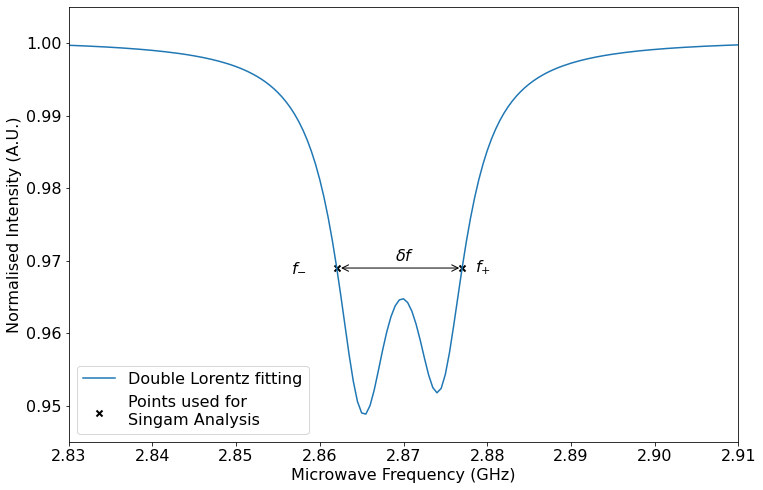

In [145]:
fig4, ax4 = plot.subplots()

ax4.plot(freq, y_fit, label = 'Double Lorentz fitting')
ax4.scatter([f_minus-0.0005, f_plus+0.00045], [I_minus+0.004, I_minus+0.004], marker = 'x', color = 'k', 
            linewidth = '2', label = 'Points used for \nSingam Analysis')

ax4.annotate(s='', xy=(f_minus-0.0002, I_minus+0.004), xytext=(f_plus+0.0004, I_minus+0.004), arrowprops=dict(arrowstyle='<->'))
ax4.text(2.869, I_minus+0.005, r'$\delta f$')

ax4.text(f_minus-0.006, I_minus+0.0035, r'$f_{-}$')
ax4.text(f_plus+0.002, I_minus+0.0035, r'$f_{+}$')
ax4.axis([2.83, 2.91, 0.945, 1.005])

ax4.set_xlabel('Microwave Frequency (GHz)')
ax4.set_ylabel('Normalised Intensity (A.U.)')
ax4.legend()

#fig4.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\' + 'Signam_analysis_01' + '.pdf')

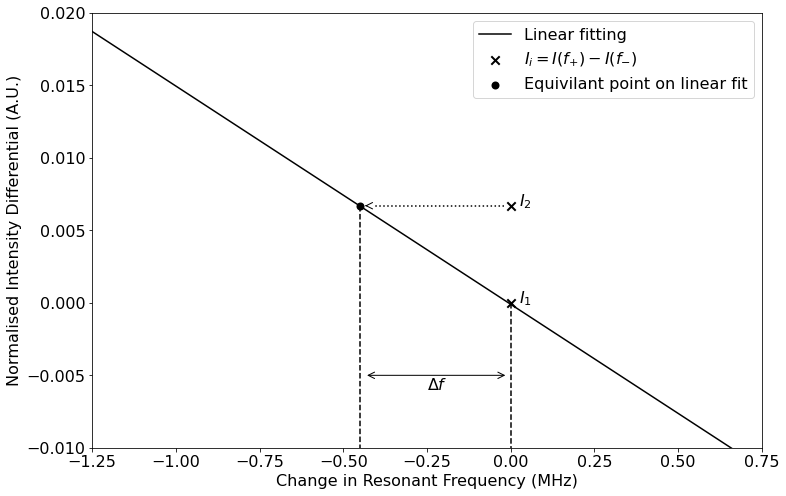

In [72]:
fig7, ax7 = plot.subplots()

ax7.plot(freq_high_res-4.5, linear_fit, label = 'Linear fitting', color = 'k')

ax7.set_xlabel('Change in Resonant Frequency (MHz)')
ax7.set_ylabel('Normalised Intensity Differential (A.U.)')
#ax7.axis([-30, 40, -0.06, 0.06])
ax7.legend(loc = 'lower left')

ax7.scatter(0,0, linewidth = '2', marker = 'x', color = 'k', s = 70)
ax7.scatter(0, 0.0067, linewidth = '2', marker = 'x', color = 'k', 
            s = 70, label = r'$I_i = I(f_{+}) - I(f_{-})$')

ax7.scatter(-0.450, 0.0067, linewidth = '2', marker = 'o', color = 'k', label = 'Equivilant point on linear fit')

ax7.axis([-1.25, 0.75, -0.01, 0.02])

x_line = np.linspace(-0.45, 0, 10)
y_line = np.linspace(0, 0.0067, 10)

x_y = np.linspace(0.0067, 0.0067, 10)
y_x = np.linspace(-0, -0, 10)

#ax7.plot(x_line, x_y, linestyle = ':', color = 'k')
plot.annotate(s='', xy=(-0.43, 0.0067), xytext=(-0.435, 0.0067), arrowprops=dict(arrowstyle='<-'))
#plot.show()
#ax7.plot(y_x, y_line, linestyle = ':', color = 'k')

ax7.text(0.025, 0, r'$I_1$')
ax7.text(0.025, 0.0067, r'$I_2$')
ax7.text(-0.25, -0.006, r'$\Delta f $')

x2 = [0,0]
x3 = [-0.45, -0.45]

y2 = [0, -0.15]
y3 = [0.0067, -0.15]

ax7.plot(x2, y2, linestyle = '--', color = 'k')
ax7.plot(x3, y3, linestyle = '--', color = 'k')

ax7.plot([-0.02, -0.41], [0.0067, 0.0067], linestyle = ':', color = 'k')

plot.annotate(s='', xy=(-0.01, -0.005), xytext=(-0.435, -0.005), arrowprops=dict(arrowstyle='<->'))

plot.legend()

#fig7.savefig('H:\\My Documents\\Strathclyde_Back_up\\Thesis and Planning\\Thesis_plots\\' + 'Signam_analysis_03' + '.pdf')


In [37]:
0.02*200*8*3.5

112.0

In [36]:
0.025*250*8*3.5

175.0

In [40]:
0.97*np.sqrt(224)

14.517630660682892

In [41]:
14.5/1.8

8.055555555555555